# Process Data from NOAA

In this article, we will download sea surface temperature (SST) data from NOAA and process it for use in machine learning models. The dataset we will use is the [NOAA Extended Reconstructed SST V5](https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html).

You can also download the preprocessed data from [here](https://drive.google.com/drive/folders/1COWlUBZANGQFVO43N4X53nW3wyZdJqGW?usp=sharing).


<a href="https://colab.research.google.com/github/peterjsadowski/tutorial_climate_ai/blob/main/03_process_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In order to make plots, we will need some additional libraries. These can be imported using `pip` if they are not already installed.

In [1]:
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import xarray as xr
import urllib.request
import os

Now we can download a file containing  historical SST means.

In [2]:

# Get data from NOAA
url = 'https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc'
filename = 'data/' + url.split('/')[-1] # Translate url into a filename

if os.path.exists(filename):
    print(f'Found {filename}')
else:
    # Try to download from NOAA
    try:
        urllib.request.urlretrieve(url, filename)
        print(f'File downloaded to {filename}')
    except Exception as e:
        print(f'Error downloading file: {e}')

Found data/sst.mnmean.nc


We will slice the area of interest.

In [3]:
ersst_data = (
    xr.open_dataset("data/sst.mnmean.nc")
    .sst.sortby("lat")
    .sel(lat=slice(-40, 40), lon=slice(120, 290))
)
ersst_data

<xarray.DataArray 'sst' (time: 2055, lat: 41, lon: 86)> Size: 29MB
[7245930 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 164B -40.0 -38.0 -36.0 -34.0 ... 34.0 36.0 38.0 40.0
  * lon      (lon) float32 344B 120.0 122.0 124.0 126.0 ... 286.0 288.0 290.0
  * time     (time) datetime64[ns] 16kB 1854-01-01 1854-02-01 ... 2025-03-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

In [5]:
clim_period = slice("1991", "2020")
ersst_clim = ersst_data.sel(time=clim_period).groupby("time.month").mean("time")
ersst_anom = ersst_data.groupby("time.month") - ersst_clim

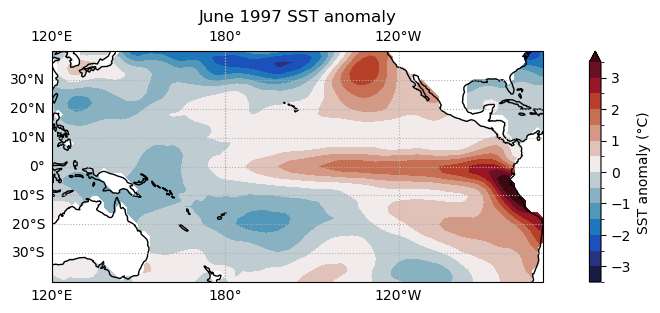

In [7]:
fig, ax = plt.subplots(
    figsize=(12, 3), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180))
)
ersst_anom.sel(time="1997-06").squeeze().plot.contourf(
    ax=ax,
    cmap=cmo.balance,
    levels=[-3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5],
    transform=ccrs.PlateCarree(),
    cbar_kwargs=dict(label="SST anomaly (°C)"),
)
ax.coastlines()
# ax.set_extent([120, 290, -40, 40], crs=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, linestyle=":")
gl.xlabels_top = False
gl.ylabels_right = False

ax.set_title("June 1997 SST anomaly")
fig.savefig("ersst_anom.png", bbox_inches="tight", dpi=300)

In [8]:
ersst_anom = ersst_anom.drop("month")
ersst_anom.name = "ssta"
ersst_anom

/tmp/ipykernel_62941/152856574.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ersst_anom = ersst_anom.drop("month")


<xarray.DataArray 'ssta' (time: 2055, lat: 41, lon: 86)> Size: 29MB
array([[[-0.84033966, -0.6383381 , -0.44122028, ..., -1.056593  ,
                 nan,         nan],
        [-1.1388769 , -0.8984375 , -0.6104984 , ..., -1.1311932 ,
                 nan,         nan],
        [-1.450161  , -1.2052517 , -0.8193588 , ..., -1.0845127 ,
                 nan,         nan],
        ...,
        [        nan, -0.04257154, -1.0953655 , ...,  1.0166531 ,
          0.6275406 ,  0.37892342],
        [ 1.755795  ,  0.87201786, -0.3320918 , ...,  0.7862549 ,
          0.44330692,  0.21854591],
        [ 2.1786861 ,  1.3697758 ,  0.0896554 , ...,  0.43834448,
          0.03181553, -0.2446928 ]],

       [[-1.2137566 , -1.049015  , -0.9198904 , ..., -1.1637831 ,
                 nan,         nan],
        [-1.3218689 , -1.113409  , -0.92447853, ..., -1.2949009 ,
                 nan,         nan],
        [-1.408701  , -1.1967564 , -0.9477997 , ..., -1.3191166 ,
                 nan,         nan],
...
        [        nan,  0.73945665,  0.6316829 , ..., -0.47609425,
         -0.3282318 , -0.12079239],
        [ 0.82754445,  0.76593375,  0.6792836 , ..., -0.7462959 ,
         -0.6401119 , -0.4321909 ],
        [ 0.86774695,  0.8088881 ,  0.7178502 , ..., -0.8241582 ,
         -0.761508  , -0.6525793 ]],

       [[ 0.54204464,  0.57256126,  0.5639982 , ...,  0.28947544,
                 nan,         nan],
        [ 0.590889  ,  0.6015701 ,  0.5787926 , ...,  0.32032967,
                 nan,         nan],
        [ 0.624197  ,  0.61104965,  0.5675945 , ...,  0.2996006 ,
                 nan,         nan],
        ...,
        [        nan,  0.28505373,  0.23413944, ..., -0.07979488,
         -0.05720711, -0.06540489],
        [ 0.49051666,  0.46675253,  0.44392395, ..., -0.13869953,
         -0.10363293, -0.08069706],
        [ 0.52953005,  0.53878736,  0.54598594, ..., -0.12417412,
         -0.07702112, -0.05340385]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 164B -40.0 -38.0 -36.0 -34.0 ... 34.0 36.0 38.0 40.0
  * lon      (lon) float32 344B 120.0 122.0 124.0 126.0 ... 286.0 288.0 290.0
  * time     (time) datetime64[ns] 16kB 1854-01-01 1854-02-01 ... 2025-03-01

In [9]:
ersst_anom.isel(time=slice(1, -4)).to_netcdf("data/ersst_pacific_anom.nc")

In [10]:
en34 = ersst_anom.sel(lat=slice(-5, 5), lon=slice(190, 240)).mean(("lat", "lon"))
oni = en34.rolling(time=3, center=True).mean().dropna("time")

In [11]:
# 0 for neutral, 1 for nino, 2 for nina

# nino when oni is above 0.5 for 5 consecutive months
nino = ((oni > 0.5).astype(int).rolling(time=5).sum() == 5).astype(int)
nino = nino.where(nino).bfill("time", limit=4).fillna(0)

# nina when oni is below -0.5 for 5 consecutive months
nina = ((oni < -0.5).astype(int).rolling(time=5).sum() == 5).astype(int)
nina = nina.where(nina).bfill("time", limit=4).fillna(0)
nina = nina * 2

enso_class = nino + nina
enso_class.name = "enso_class"
enso_class

<xarray.DataArray 'enso_class' (time: 2053)> Size: 16kB
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
  * time     (time) datetime64[ns] 16kB 1854-02-01 1854-03-01 ... 2025-02-01

In [12]:
enso_class.to_netcdf("data/enso_class.nc")

In [13]:
class_labels = xr.open_dataarray("data/enso_class.nc")
labels = class_labels.rolling(time=3).construct("lead").shift(time=-3).dropna("time")
labels["lead"] = [1, 2, 3]
labels

<xarray.DataArray 'enso_class' (time: 2050, lead: 3)> Size: 49kB
array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 2.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])
Coordinates:
  * time     (time) datetime64[ns] 16kB 1854-02-01 1854-03-01 ... 2024-11-01
  * lead     (lead) int64 24B 1 2 3

In [14]:
labels_df = labels.to_pandas().reset_index()
labels_df.columns = ["time", "lead_1", "lead_2", "lead_3"]
labels_df.to_csv("data/labels.csv", index=False)

In [15]:
ersst_anom.isel(time=-1, drop=True).to_netcdf("data/ersst_anom_dec2023.nc")

# Prepare data for Autoregressive Model

In [14]:
# Get Pacific region for all months 1854--2025
ersst_data = (
    xr.open_dataset("data/sst.mnmean.nc")
    .sst.sortby("lat")
    .sel(lat=slice(-40, 40), lon=slice(120, 290))
)

clim_period = slice("1854", "2025")
ersst_clim = ersst_data.sel(time=clim_period).groupby("time.month").mean("time")
ersst_anom = ersst_data.groupby("time.month") - ersst_clim
ersst_anom.name = "ssta"

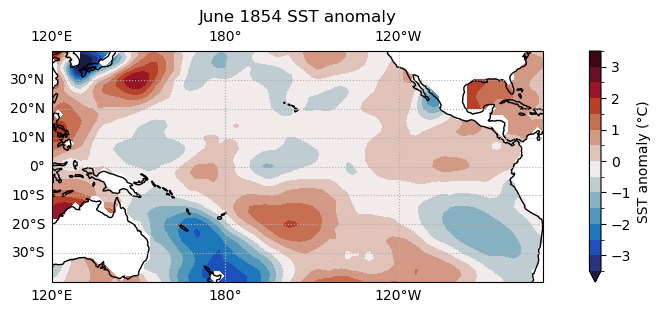

In [9]:
# Plot example
fig, ax = plt.subplots(
    figsize=(12, 3), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180))
)
ersst_anom.sel(time="1854-01").squeeze().plot.contourf(
    ax=ax,
    cmap=cmo.balance,
    levels=[-3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5],
    transform=ccrs.PlateCarree(),
    cbar_kwargs=dict(label="SST anomaly (°C)"),
)
ax.coastlines()
# ax.set_extent([120, 290, -40, 40], crs=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, linestyle=":")
gl.xlabels_top = False
gl.ylabels_right = False

ax.set_title("June 1854 SST anomaly")
fig.savefig("ersst_anom.png", bbox_inches="tight", dpi=300)

In [17]:
print(ersst_anom.shape)
ersst_anom.to_netcdf("data/ersst_pacific_anom_1854_2025.nc")

(2055, 41, 86)
